`Firefly` (https://www.icg.port.ac.uk/firefly/) is one of the
spectral fitting codes I would like to include in the project. 
To test any of the fitting codes, I will run it on source 
spectra forward modeled from galaxy formation models. 


__In this notebook__ I test `Firefly` out on Rita's L-Gal source
spectra. 

In [1]:
import numpy as np 
from astropy.io import fits
from astropy import units as U
from astropy import constants as Const
import astropy.cosmology as co
# -- firefly -- 
import GalaxySpectrumFIREFLY as gs
import StellarPopulationModel as spm
from firefly_dust import get_dust_radec
# -- FOMOspec -- 
from FOMOspec import util as UT
from FOMOspec import spectra as Spec
from FOMOspec import fitters as Fitters

In [2]:
import matplotlib as mpl 
import matplotlib.pyplot as pl 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

In [3]:
def SpecInput(galid): 
    f_name = 'gal_spectrum_'+str(galid)+'_BGS_template_BC03_Stelib.fits'
    f_inspec = fits.open(''.join([UT.dat_dir(), 'Lgal/templates/', f_name]))
    specin = f_inspec[1].data
    output = {}
    output['redshift'] = f_inspec[0].header['REDSHIFT']
    output['wave'] = specin['wave']
    output['flux'] = specin['flux_dust_nonoise'] * 1e-4 * 1e7 *1e17 #from W/A/m2 to 10e-17 erg/s/A/cm2
    output['flux_dust_nonoise'] = specin['flux_dust_nonoise'] * 1e-4 * 1e7 *1e17 
    output['flux_nodust_nonoise'] = specin['flux_nodust_nonoise'] * 1e-4 * 1e7 *1e17
    return output

Text(0,0.5,'flux [$10^{-17} erg/s/\\AA/cm^2$]')

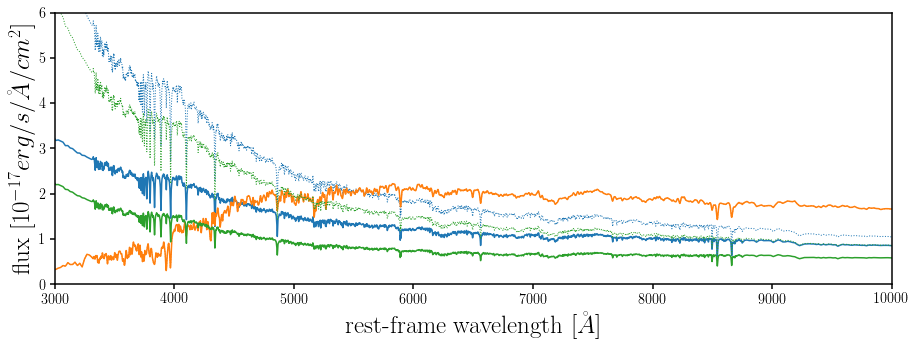

In [4]:
fig = plt.figure(figsize=(15,5)) 
sub = fig.add_subplot(111)
for ii, idd in enumerate([101314, 253044, 10924]): 
    spec_in = SpecInput(idd)
    sub.plot(spec_in['wave']/(1.+spec_in['redshift']), spec_in['flux_dust_nonoise'], c='C'+str(ii))
    sub.plot(spec_in['wave']/(1.+spec_in['redshift']), spec_in['flux_nodust_nonoise'], c='C'+str(ii), ls=':', lw=1)
sub.set_xlim([3e3, 1e4])
sub.set_xlabel('rest-frame wavelength [$\AA$]', fontsize=25)
sub.set_ylim([0., 6])
sub.set_ylabel('flux [$10^{-17} erg/s/\AA/cm^2$]', fontsize=25)

In [18]:
def firefly_bestfit(galid): 
    speci = SpecInput(galid)
    gspec = Spec.GSfirefly()
    gspec.generic(speci['wave'], speci['flux_dust_nonoise'], redshift=speci['redshift'])
    gspec.path_to_spectrum = UT.dat_dir()
    
    f_name = 'firefly.gal_spectrum_'+str(galid)+'_BGS_template_BC03_Stelib.hdf5'
    f_firefly = ''.join([UT.dat_dir(), 'Lgal/templates/', f_name])
    
    firefly = Fitters.Firefly(gspec,
                          f_firefly, # output file 
                          co.Planck13, # comsology
                          models = 'm11', # model ('m11', 'bc03', 'm09') 
                          model_libs = ['MILES'], # model library for M11
                          imfs = ['cha'], # IMF used ('ss', 'kr', 'cha')
                          hpf_mode = 'on', # uses HPF to dereden the spectrum                       
                          age_limits = [0, 15], 
                          Z_limits = [-3., 5.], 
                          wave_limits = [3350., 9000.], 
                          suffix=None, 
                          downgrade_models = False, 
                          data_wave_medium = 'vacuum', 
                          use_downgraded_models = False, 
                          write_results = True)
    bestfit = firefly.fit_models_to_data()
    return bestfit, firefly

In [19]:
bestfits, fireflies = [], [] 
for ii, idd in enumerate([101314, 253044, 10924]): 
    bfit, ffly = firefly_bestfit(idd)
    bestfits.append(bfit)
    fireflies.append(ffly)

getting the models
takes 0.026155
Matching models to data
takes 0.232400
Normalising the models
takes 0.000301
Correction from dust attentuation


/Users/chang/projects/firefly_release/python/firefly_library.py:291: RuntimeWarning: divide by zero encountered in double_scalars
  mass_factor[m] 			= data_norm/model_norm[m]
/Users/chang/projects/firefly_release/python/firefly_library.py:292: RuntimeWarning: invalid value encountered in true_divide
  normed_model_flux[m] 	= model_flux[m] / model_norm[m] * data_norm
/Users/chang/anaconda2/lib/python2.7/site-packages/scipy/stats/stats.py:2637: RuntimeWarning: invalid value encountered in greater
  c = c[(c > critlower) & (c < critupper)]
/Users/chang/anaconda2/lib/python2.7/site-packages/scipy/stats/stats.py:2637: RuntimeWarning: invalid value encountered in less
  c = c[(c > critlower) & (c < critupper)]
/Users/chang/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/chang/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide

takes 10.763194
Calculating average properties and outputting
takes 0.002193
getting the models
takes 0.023444
Matching models to data
takes 0.233942
Normalising the models
takes 0.000300
Correction from dust attentuation


KeyboardInterrupt: 

In [ ]:
fig = plt.figure(figsize=(15,5)) 
sub = fig.add_subplot(111)
for ii, idd in enumerate([101314]):#, 253044, 10924]): 
    spec_in = SpecInput(idd)
    sub.plot(spec_in['wave']/(1.+spec_in['redshift']), spec_in['flux_nodust_nonoise'], c='C'+str(ii+1), label='LGal spectra')
    #w, firefly_fit = firefly_bestfit(idd)
    firefly_fit = bestfits[ii]
    #sub.plot(firefly_fit['wavelength'], firefly_fit['flux_data'])
    sub.plot(firefly_fit['wavelength'], firefly_fit['flux_bestfit'], c='k', ls='--', label='FIREFLY best-fit')
    if ii == 0: 
        sub.legend(loc='upper right', fontsize=20)
sub.set_xlim([3e3, 1e4])
sub.set_xlabel('Wavelength [$\AA$]', fontsize=25)
sub.set_ylim([0., 5])
sub.set_ylabel('flux [$10^{-17} erg/s/\AA/cm^2$]', fontsize=25)

Text(0,0.5,'flux [$10^{-17} erg/s/\\AA/cm^2$]')

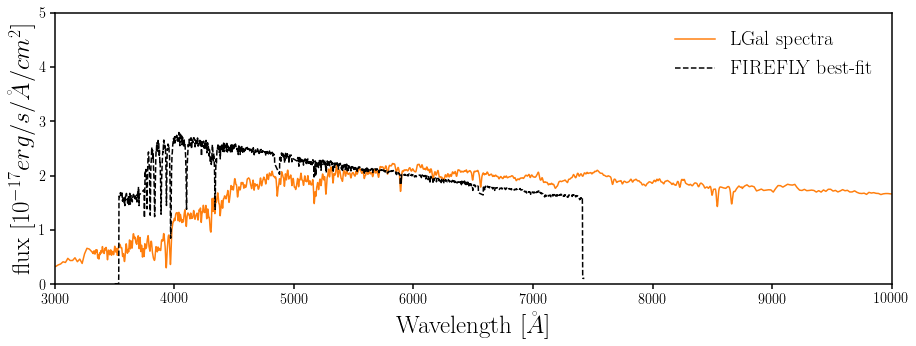

In [17]:
fig = plt.figure(figsize=(15,5)) 
sub = fig.add_subplot(111)
for ii, idd in enumerate([253044]):#, 10924]): 
    spec_in = SpecInput(idd)
    sub.plot(spec_in['wave']/(1.+spec_in['redshift']), spec_in['flux_nodust_nonoise'], c='C'+str(ii+1), label='LGal spectra')
    #w, firefly_fit = firefly_bestfit(idd)
    firefly_fit = bestfits[ii]
    #sub.plot(firefly_fit['wavelength'], firefly_fit['flux_data'])
    sub.plot(firefly_fit['wavelength'], firefly_fit['flux_bestfit'], c='k', ls='--', label='FIREFLY best-fit')
    if ii == 0: 
        sub.legend(loc='upper right', fontsize=20)
sub.set_xlim([3e3, 1e4])
sub.set_xlabel('Wavelength [$\AA$]', fontsize=25)
sub.set_ylim([0., 5])
sub.set_ylabel('flux [$10^{-17} erg/s/\AA/cm^2$]', fontsize=25)

`FIREFLY` best-fit to LGal source spectra